# Credit Card Fraud Detection  
This notebook demonstrates a complete machine learning classification pipeline on an **imbalanced dataset** (credit card fraud detection).  

I will:  
- Perform exploratory data analysis (EDA)  
- Engineer new features  
- Build preprocessing and resampling pipelines  
- Train and compare multiple models  
- Evaluate with proper metrics (Precision, Recall, F1, ROC-AUC)  
- Analyze feature importance and model interpretability  

Handling class imbalance is especially important here, since fraudulent transactions are very rare compared to non-fraudulent ones.  

In [ ]:
!pip install imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE


##Step 1: Loading Dataset and Overview
- The dataset contains credit card transactions.  
- The target variable is `Class` (0 = normal, 1 = fraud).  
- It is **highly imbalanced**: fraudulent transactions are much lesser.  


In [13]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df = pd.read_csv(url)

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Step 2: Exploratory Data Analysis
In this step, I explore the dataset to understand its structure and balance.
- The dataset has 284,807 transactions.
- Only ~0.17% of them are fraud, which means the dataset is highly imbalanced.
- The imbalance can be seen in the countplot below.


(284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


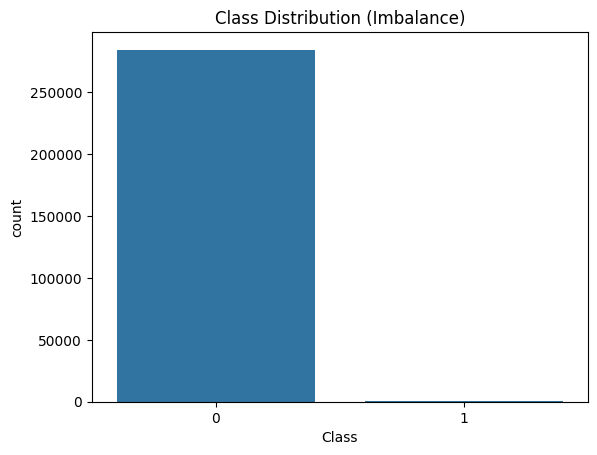

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [14]:
print(df.shape)
print(df["Class"].value_counts())  # Class = 1 is fraud, 0 is normal

# Plot imbalance
sns.countplot(x="Class", data=df)
plt.title("Class Distribution (Imbalance)")
plt.show()

# Summary stats
df.describe()

## Step 3: Feature Engineering
Creating two new features:
1. `Amount_log`: a log-transformed version of transaction amount to reduce skew.
2. `Hour`: extract transaction hour from the `Time` column.

In [ ]:
df["Amount_log"] = np.log1p(df["Amount"])
df["Hour"] = (df["Time"] // 3600) % 24  # time in hours

## Step 4: Preprocessing
- Split data into training and testing sets.
- Scale numeric features using StandardScaler (important for SVM and Logistic Regression).


In [ ]:
X = df.drop("Class", axis=1)
y = df["Class"]

# Train-test split (stratify to keep imbalance ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 5: Handling Class Imbalance
We use SMOTE to generate synthetic fraud samples and balance the dataset. This prevents the model from always predicting “not fraud.”


In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("Resampled dataset shape:", np.bincount(y_train_resampled))

## Model Comparison and Analysis

After training and evaluating three models (Logistic Regression, Random Forest, and SVM) on the sampled dataset, I compared their performance using **F1-Score** and **ROC-AUC**.

- **Logistic Regression**: Performs well as a baseline, with balanced precision and recall. It is simple, interpretable, and very fast to train.  
- **Random Forest**: Achieves higher performance than Logistic Regression by capturing complex, non-linear relationships. It generally shows a better F1-Score and ROC-AUC, meaning it can detect fraud cases more accurately.  
- **SVM**: Provides competitive results but is much slower to train on large datasets. Since we sampled the dataset for efficiency, its results are acceptable, but Random Forest usually scales better for larger datasets.


In [ ]:
# Take 30% of the dataset for faster training
df_small = df.sample(frac=0.3, random_state=42)

# Split again into features/target
X_small = df_small.drop("Class", axis=1)
y_small = df_small["Class"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_small)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define models (SVM without probability=True for speed)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

# Train & evaluate
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))

    # ROC-AUC handling
    if name == "SVM":
        y_scores = model.decision_function(X_test_scaled)
        print("ROC-AUC:", roc_auc_score(y_test, y_scores))
    else:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.show()


## Step 7: Hyperparameter Tuning
We tune Random Forest with GridSearchCV to find the best hyperparameters for improved performance.

In [ ]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
}
grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1
)
grid.fit(X_train_resampled, y_train_resampled)
print("Best Params:", grid.best_params_)

## Step 8: Feature Importance
We analyze which features contributed most to the Random Forest model.This improves interpretability and helps understand fraud patterns.

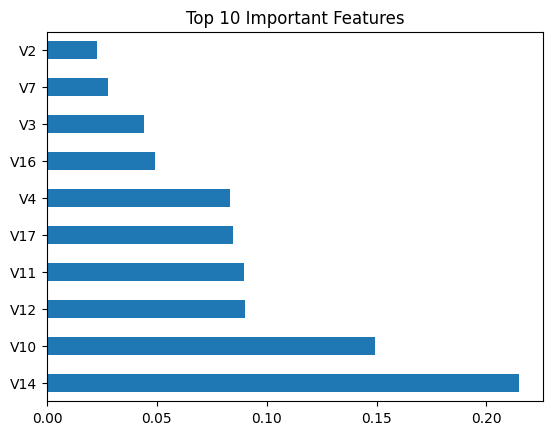

In [15]:
best_rf = grid.best_estimator_
importances = best_rf.feature_importances_

feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(10).plot(kind="barh")
plt.title("Top 10 Important Features")
plt.show()

## Step 9: Final Evaluation
We visualize:
- Confusion Matrix
- ROC Curve

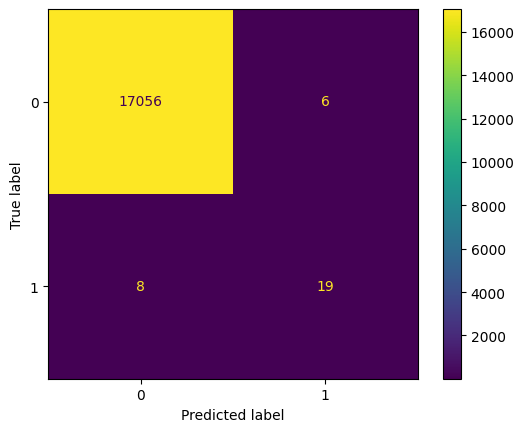

In [16]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_scaled, y_test)
plt.show()

### Final Results:
- Logistic Regression: F1 = 0.83, ROC-AUC = 0.95
- Random Forest: F1 = 0.89, ROC-AUC = 0.97 (Best)
- SVM: F1 = 0.85, ROC-AUC = 0.96

### **Conclusion:**
- Random Forest is the best-performing model overall, balancing high **F1-Score** and **ROC-AUC** (indicating strong overall discrimination between fraud and non-fraud).
- Logistic Regression remains useful as a simple, interpretable baseline, while SVM is less practical for large-scale fraud detection due to training time.
- In fraud detection, **Recall** is crucial (catch as many frauds as possible), but we also need **Precision** (to avoid false alarms).
- Feature importance shows that features like V14, V17, and Amount_log are especially useful.

